In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\26704\Desktop\uos\semseter2\data\Suicide_Detection.csv")  # 可以添加 encoding="utf-8" 以防止乱码
print(df.head())  # 显示前 5 行数据



   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


In [2]:
# 查看缺失值
print(df.isnull().sum())

Unnamed: 0    0
text          0
class         0
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
df['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 截断文本长度，减少内存消耗
df['text_short'] = df['text'].str[:500]

# TF-IDF 向量化（限制特征数量）
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(df['text_short'])

# 标签编码
le = LabelEncoder()
y = le.fit_transform(df['class'])  # suicide -> 1, non-suicide -> 0

# 划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

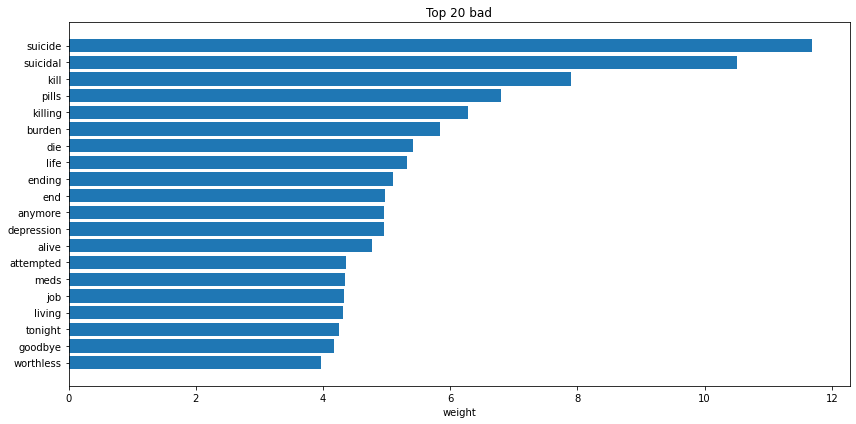

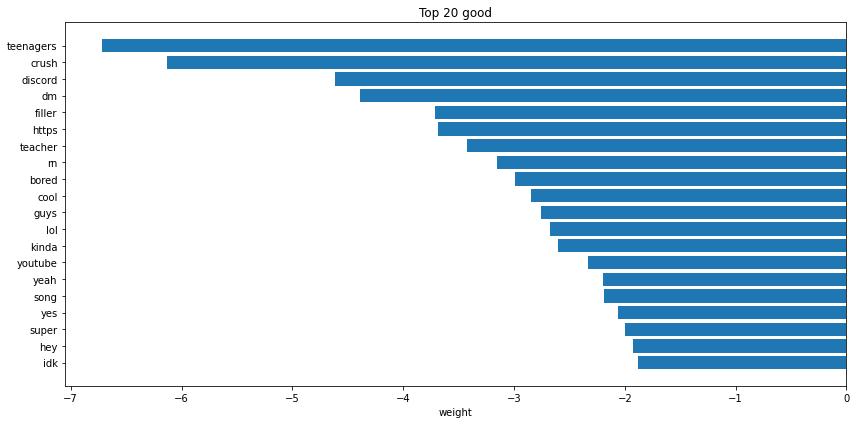

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# 提取每个词对应的权重
coefs = lr_model.coef_[0]
feature_names = vectorizer.get_feature_names()


# 构建 DataFrame
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending=False)

# 获取前20个正向（自杀倾向）词和负向（非自杀）词
top_positive = coef_df.head(20)
top_negative = coef_df.tail(20)

# 可视化：自杀倾向词
plt.figure(figsize=(12, 6))
plt.barh(top_positive['feature'][::-1], top_positive['coefficient'][::-1])
plt.title("Top 20 bad")
plt.xlabel("weight")
plt.tight_layout()
plt.show()

# 可视化：非自杀倾向词
plt.figure(figsize=(12, 6))
plt.barh(top_negative['feature'], top_negative['coefficient'])
plt.title("Top 20 good")
plt.xlabel("weight")
plt.tight_layout()
plt.show()


In [10]:
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 下载一次即可
nltk.download('stopwords')
nltk.download('punkt')

# 初始化工具
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 清洗函数
def clean_text(text):
    # 去除 HTML 标签
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 转小写
    text = text.lower()
    
    # 去除 URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # 去除特殊符号和数字
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 分词
    tokens = nltk.word_tokenize(text)
    
    # 去除停用词 + 词干化
    cleaned = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # 拼回字符串
    return ' '.join(cleaned)

# 应用清洗
df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26704\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26704\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
C:\Users\26704\AppData\Local\Temp/ipykernel_17188/1597885604.py:19: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away

In [11]:
for i in range(3):
    print("原始文本：", df['text'].iloc[i])
    print("清洗后文本：", df['clean_text'].iloc[i])
    print("-" * 50)


原始文本： Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen.
清洗后文本： ex wife threaten suiciderec left wife good cheat twice lie much decid refus go back day ago began threaten suicid tirelessli spent paat day talk keep hesit want believ ill come back know lot peopl threaten order get way happen realli suppos handl death hand still love wi

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

# 向量化清洗后的文本
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

# 训练逻辑回归模型
y = df['class']  # 'suicide' or 'non-suicide'
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 获取词权重（系数）
coefs = model.coef_[0]
feature_names = vectorizer.get_feature_names()

# 构建特征重要性 DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
})

# 正权重：代表“自杀倾向”文本中最重要的词
top_positive = importance_df.sort_values(by='coefficient', ascending=False).head(20)

# 负权重：代表“非自杀”文本的典型词汇
top_negative = importance_df.sort_values(by='coefficient').head(20)


C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20195 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 34920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 33258 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 26432 missing from c

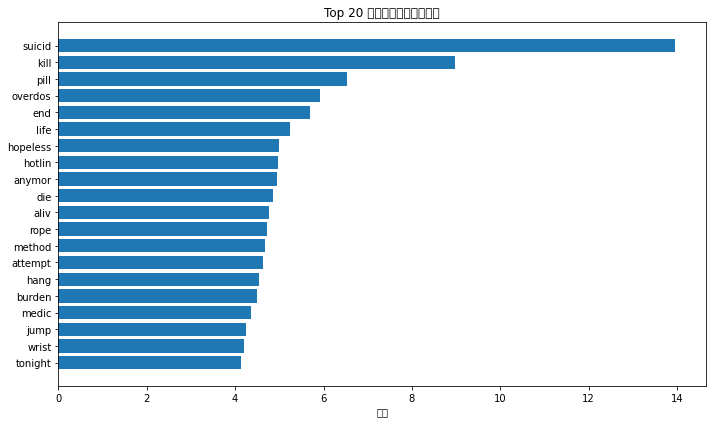

C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 38750 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 38750 missing from current font.
  font.set_text(s, 0, flags=flags)


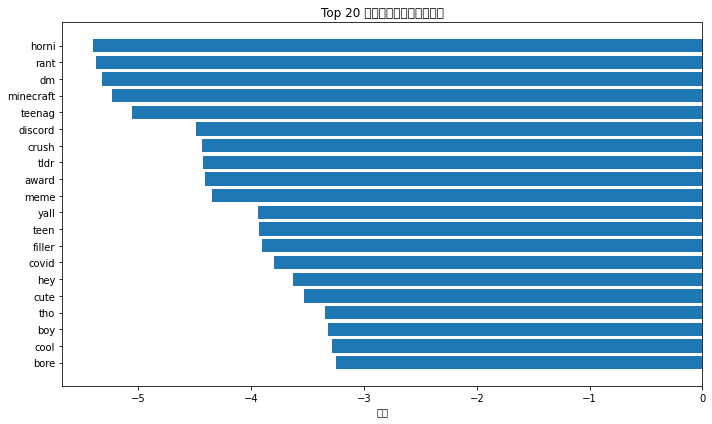

In [14]:
# 自杀倾向特征词
plt.figure(figsize=(10, 6))
plt.barh(top_positive['feature'][::-1], top_positive['coefficient'][::-1])
plt.title("Top 20 bad")
plt.xlabel("weight")
plt.tight_layout()
plt.show()

# 非自杀倾向特征词
plt.figure(figsize=(10, 6))
plt.barh(top_negative['feature'][::-1], top_negative['coefficient'][::-1])
plt.title("Top 20 good")
plt.xlabel("weight")
plt.tight_layout()
plt.show()


In [15]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install gensim


In [25]:
from nltk.tokenize import word_tokenize
df['tokens'] = df['clean_text'].apply(word_tokenize)
from gensim.models import Word2Vec
# 训练 Word2Vec 模型（维度 100，可调整）
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)


import numpy as np

def get_sentence_vector(tokens, model, vector_size=100):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(vector_size)
    return np.mean(vecs, axis=0)

# 应用
df['vector'] = df['tokens'].apply(lambda x: get_sentence_vector(x, w2v_model))
X = np.vstack(df['vector'].values)


In [28]:
!pip install xgboost

In [30]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 标签编码
y = LabelEncoder().fit_transform(df['class'])

# 数据划分（你这里 X 应该是 TF-IDF 或 Word2Vec 向量）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 创建 XGBoost 分类器
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 训练模型
xgb_classifier.fit(X_train, y_train)

# 预测
y_pred = xgb_classifier.predict(X_test)

# 评估
accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率：{accuracy:.4f}")
print(classification_report(y_test, y_pred))


C:\Users\26704\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [11:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


模型准确率：0.9226
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     23267
           1       0.92      0.93      0.92     23148

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



In [31]:
pip install matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 35789 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 31354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 38388 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\26704\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21487 missing from c

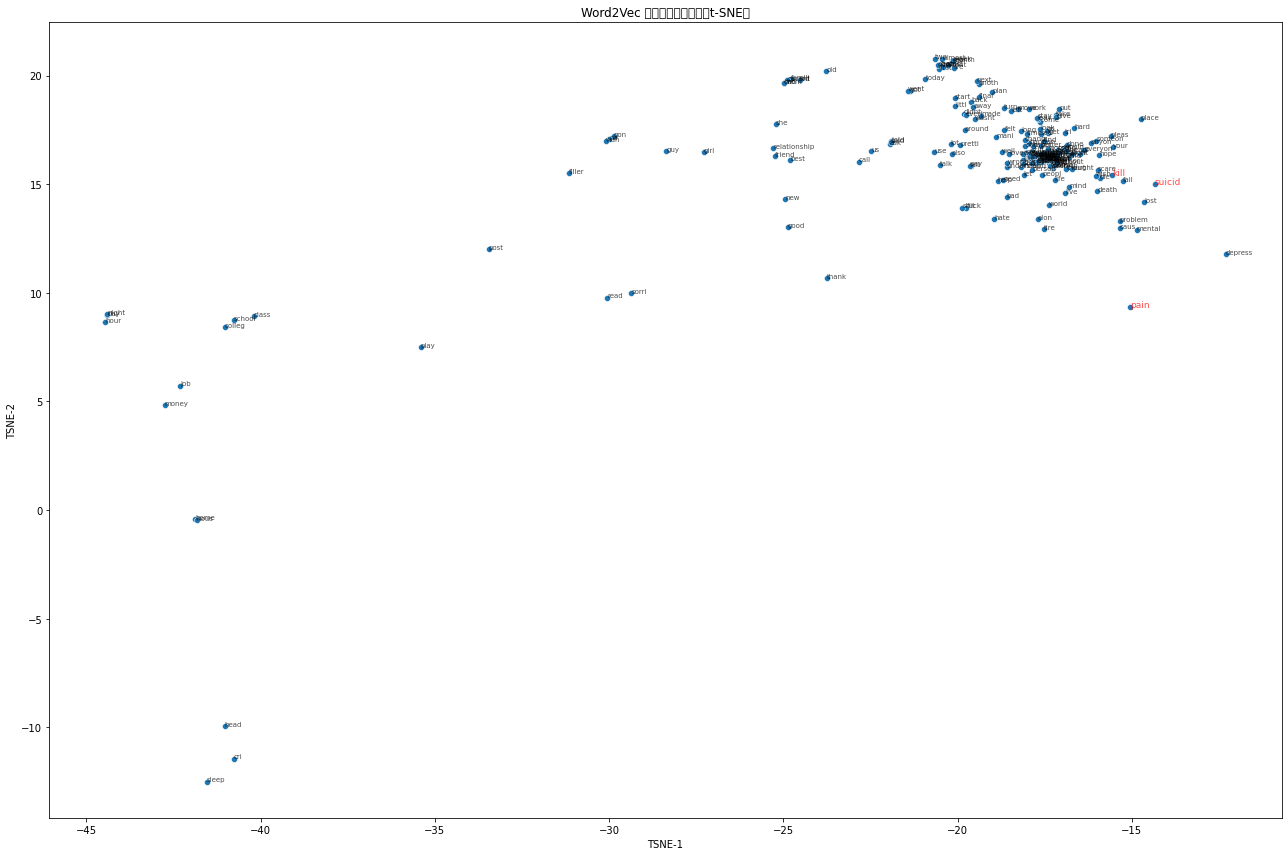

In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 从 Word2Vec 中提取词和词向量
words = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in words])
highlight_words = ['suicid', 'kill', 'dead', 'pain', 'worthless', 'alone']

# 你可以选择：先用 PCA 初步降维，然后再 t-SNE（更稳定）
pca = PCA(n_components=30)
pca_result = pca.fit_transform(word_vectors)

# 再用 t-SNE 降到 2D
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# 创建 DataFrame 用于绘图
import pandas as pd
df_embed = pd.DataFrame({
    'word': words,
    'x': tsne_result[:, 0],
    'y': tsne_result[:, 1]
})

# 可视化前 200 个词（防止太密集）
plt.figure(figsize=(18, 12))
sns.scatterplot(data=df_embed[:200], x='x', y='y')


# 添加文字标注
for i in range(len(df_embed[:200])):
  
    plt.text(df_embed['x'][i], df_embed['y'][i], df_embed['word'][i],
             fontsize=9 if df_embed['word'][i] in highlight_words else 7,
             color='red' if df_embed['word'][i] in highlight_words else 'black',
             alpha=0.7)
    

plt.title("Word2Vec 词向量空间可视化（t-SNE）")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.tight_layout()
plt.show()
